In [67]:

import subprocess
import csv
import re
import sys
# import os
import matplotlib.pyplot as plt
import numpy as np
import random
import plotly.graph_objects as go

In [68]:
def extract_numeric(value):
    # Remove commas and whitespace from the value
    value = value.replace(',', '').strip()
    match = re.search(r'[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?', value)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return 0.0
    else:
        return 0.0

In [69]:
def run_ncu(command_list: list) -> str:
    print("Target program:", command_list)

    ncu_command = [
        'ncu',
        '--csv',
        '--metrics',
        'sm__sass_thread_inst_executed_op_dfma_pred_on.sum,\
sm__sass_thread_inst_executed_op_ffma_pred_on.sum,\
sm__sass_thread_inst_executed_op_dmul_pred_on.sum,\
sm__sass_thread_inst_executed_op_dadd_pred_on.sum,\
sm__sass_thread_inst_executed_op_fmul_pred_on.sum,\
sm__sass_thread_inst_executed_op_fadd_pred_on.sum,\
sm__sass_thread_inst_executed_op_imul_pred_on.sum,\
sm__sass_thread_inst_executed_op_iadd_pred_on.sum,\
smsp__thread_inst_executed_pred_on.sum,\
dram__bytes.sum,\
gpu__time_duration.sum',
    ] + command_list  # Append the command list
    
    print("Profiling command:", ' '.join(ncu_command))

    print("Running Nsight Compute...")

    result = subprocess.run(ncu_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)

    if result.returncode != 0:
        print(f"Error running ncu: {result.stderr}")
        sys.exit(1)
    return result.stdout

In [70]:
# Update the parse_ncu_output function to have consistent key labels.
def parse_ncu_output(ncu_output):
    kernels = {}
    reader = csv.reader(ncu_output.strip().split('\n'))
    headers = []

    for row in reader:
        if not row:
            continue
        if row[0].startswith('=='):
            continue  # Skip ncu output messages
        if 'Kernel Name' in row:
            headers = row
            continue
        if headers and row[0] != 'ID':
            kernel_data = dict(zip(headers, row))
            kernel_name = kernel_data['Kernel Name']

            # Initialize kernel data if not already present
            if kernel_name not in kernels:
                kernels[kernel_name] = {
                    'FP32 Operations': 0.0,
                    'FP64 Operations': 0.0,
                    'Memory Traffic (Bytes)': 0.0,
                    'gpu_time_duration': 0.0,
                    'INT32 Operations': 0.0,
                    'Total Operations': 0.0
                }

            # Accumulate metrics for the kernel based on the metric name
            metric_name = kernel_data['Metric Name']
            metric_value = extract_numeric(kernel_data['Metric Value'])

            if metric_name == 'sm__sass_thread_inst_executed_op_dfma_pred_on.sum':
                kernels[kernel_name]['FP64 Operations'] += metric_value * 2
            elif metric_name == 'sm__sass_thread_inst_executed_op_ffma_pred_on.sum':
                kernels[kernel_name]['FP32 Operations'] += metric_value * 2
            elif metric_name == 'sm__sass_thread_inst_executed_op_dmul_pred_on.sum':
                kernels[kernel_name]['FP64 Operations'] += metric_value
            elif metric_name == 'sm__sass_thread_inst_executed_op_dadd_pred_on.sum':
                kernels[kernel_name]['FP64 Operations'] += metric_value
            elif metric_name == 'sm__sass_thread_inst_executed_op_fmul_pred_on.sum':
                kernels[kernel_name]['FP32 Operations'] += metric_value
            elif metric_name == 'sm__sass_thread_inst_executed_op_fadd_pred_on.sum':
                kernels[kernel_name]['FP32 Operations'] += metric_value
            elif metric_name == 'sm__sass_thread_inst_executed_op_imul_pred_on.sum':
                kernels[kernel_name]['INT32 Operations'] += metric_value
            elif metric_name == 'sm__sass_thread_inst_executed_op_iadd_pred_on.sum':
                kernels[kernel_name]['INT32 Operations'] += metric_value
            elif metric_name == 'smsp__thread_inst_executed_pred_on.sum':
                kernels[kernel_name]['Total Operations'] += metric_value
            elif metric_name == 'dram__bytes.sum':
                kernels[kernel_name]['Memory Traffic (Bytes)'] += metric_value
            elif metric_name == 'gpu__time_duration.sum':
                kernels[kernel_name]['gpu_time_duration'] += metric_value

    # Calculate performance and arithmetic intensity for each kernel
    for kernel_name, data in kernels.items():
        # Calculate arithmetic intensity and performance for FP32, FP64, and INT32
        dram_bytes = data['Memory Traffic (Bytes)']
        time_seconds = data['gpu_time_duration'] / 1e9  # Convert nanoseconds to seconds

        if dram_bytes > 0 and time_seconds > 0:
            data['FP32 AI'] = data['FP32 Operations'] / dram_bytes
            data['FP32 Performance'] = data['FP32 Operations'] / time_seconds
            data['FP64 AI'] = data['FP64 Operations'] / dram_bytes
            data['FP64 Performance'] = data['FP64 Operations'] / time_seconds
            data['INT32 AI'] = data['INT32 Operations'] / dram_bytes
            data['INT32 Performance'] = data['INT32 Operations'] / time_seconds
            data['Total AI'] = data['Total Operations'] / dram_bytes
            data['Total Performance'] = data['Total Operations'] / time_seconds
        else:
            data['FP32 AI'] = 0.0
            data['FP32 Performance'] = 0.0
            data['FP64 AI'] = 0.0
            data['FP64 Performance'] = 0.0
            data['INT32 AI'] = 0.0
            data['INT32 Performance'] = 0.0
            data['Total AI'] = 0.0
            data['Total Performance'] = 0.0

    return kernels



In [71]:
benchmark_data = {
    'GPU Model': 'RTX 4060 TI 16 GB',
    'Memory Throughput (GB/s)': 288,  # Replace with your GPU's memory bandwidth
    'FP32 Throughput (GFLOPS)': 22.06e3  # Replace with your GPU's peak FP32 performance
}
benchmark_data

{'GPU Model': 'RTX 4060 TI 16 GB',
 'Memory Throughput (GB/s)': 288,
 'FP32 Throughput (GFLOPS)': 22060.0}

In [72]:
def clean_kernel_name(kernel_name):

    #    print("original kernel_name=", kernel_name, "\n")

    # Step 1: Remove "void", OCCA labels, any spaces
    kernel_name = kernel_name.replace('void', '').replace(' ', '')
    kernel_name = kernel_name.replace('_occa_', '').replace(' ', '')
    kernel_name = kernel_name.replace('_0', '').replace(' ', '')

    # Step 2: Remove containing classes and namespaces (everything before '::')
    if '::' in kernel_name:
        kernel_name = kernel_name.split('::')[-1]

    # Step 3: Replace long template arguments (>10 chars) with <...> but leave short ones intact
    cleaned_name = ""
    in_template = False
    template_buffer = ""
    for char in kernel_name:
        if char == '<':
            in_template = True
            template_buffer += char
        elif char == '>':
            in_template = False
            if len(template_buffer) > 20:
                cleaned_name += "<...>"
            else:
                cleaned_name += template_buffer + char
            template_buffer = ""
            continue
        elif in_template:
            template_buffer += char
        else:
            cleaned_name += char

    if '(' in cleaned_name:
        cleaned_name = cleaned_name[:cleaned_name.rfind('(')]

    return cleaned_name

In [81]:
def plot_roofline_from_kernel_data(benchmark_data, kernel_data, scale='GFLOPS'):
    gpu_model = benchmark_data['GPU Model']
    mem_bandwidth = benchmark_data['Memory Throughput (GB/s)'] * 1e9  # Convert GB/s to Bytes/s
    peak_performance = benchmark_data['FP32 Throughput (GFLOPS)'] * 1e9  # Convert GFLOPS to FLOPS

    # Choose appropriate units
    if scale == 'TFLOPS':
        performance_unit = 1e12
    elif scale == 'GFLOPS':
        performance_unit = 1e9
    else:
        raise ValueError(f"Unknown scale: {scale}")

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the roofline
    ai = np.logspace(-5, 3, 100)
    bandwidth_limit = ai * mem_bandwidth / performance_unit
    compute_limit = np.full_like(ai, peak_performance / performance_unit)
    roofline = np.minimum(bandwidth_limit, compute_limit)
    ax.plot(ai, roofline, label='Roofline', linestyle='--', color='gray', linewidth=2)

    # Plot kernel data
    for kernel_name, data in kernel_data.items():
        ai_value = data['FP32 AI']
        performance = data['FP32 Performance'] / performance_unit
        ax.scatter(ai_value, performance, label=clean_kernel_name(kernel_name), s=100)

    # Labels and title
    ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)', fontsize=14)
    ax.set_ylabel(f'Performance ({scale})', fontsize=14)
    ax.set_title(f'Roofline Model for {gpu_model}', fontsize=16)

    # Logarithmic scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [82]:
def main(target_program):
    # Run Nsight Compute to collect kernel data
    kernel_data = {}
    if len(target_program) < 1:
        print("No kernels found in target program.")
        sys.exit(1) 
    else:
        exe = target_program[0]
        for i in range(1, len(target_program)):
            # Split arguments into a list
            args = target_program[i].split()
            # Combine the executable and arguments
            cmd = [exe] + args
            ncu_output = run_ncu(cmd)
            kernel_data.update(parse_ncu_output(ncu_output))
    plot_roofline_from_kernel_data(benchmark_data, kernel_data)

Target program: ['./cuda_heat_equation', '-d', '25', '100', '-b', 'N', '-m', '1d']
Profiling command: ncu --csv --metrics sm__sass_thread_inst_executed_op_dfma_pred_on.sum,sm__sass_thread_inst_executed_op_ffma_pred_on.sum,sm__sass_thread_inst_executed_op_dmul_pred_on.sum,sm__sass_thread_inst_executed_op_dadd_pred_on.sum,sm__sass_thread_inst_executed_op_fmul_pred_on.sum,sm__sass_thread_inst_executed_op_fadd_pred_on.sum,sm__sass_thread_inst_executed_op_imul_pred_on.sum,sm__sass_thread_inst_executed_op_iadd_pred_on.sum,smsp__thread_inst_executed_pred_on.sum,dram__bytes.sum,gpu__time_duration.sum ./cuda_heat_equation -d 25 100 -b N -m 1d
Running Nsight Compute...


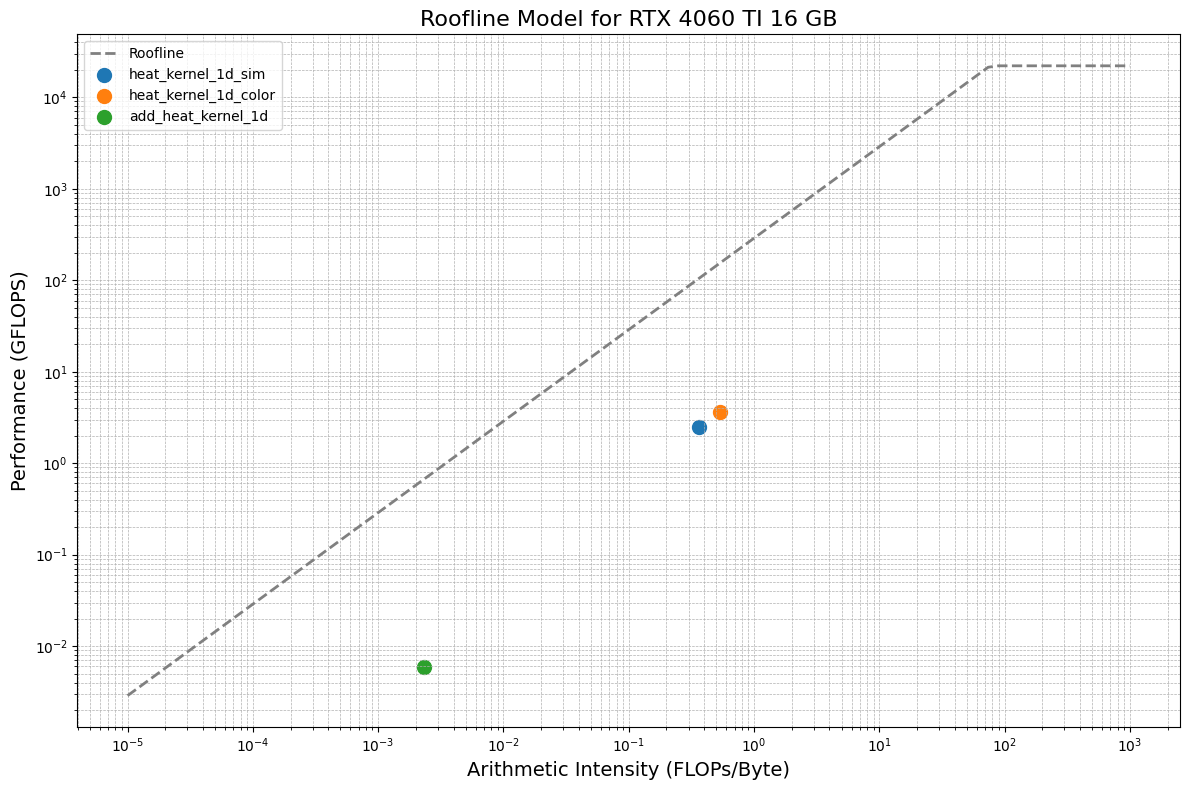

Target program: ['./cuda_heat_equation', '-d', '25', '100', '-b', 'N', '-m', '2d']
Profiling command: ncu --csv --metrics sm__sass_thread_inst_executed_op_dfma_pred_on.sum,sm__sass_thread_inst_executed_op_ffma_pred_on.sum,sm__sass_thread_inst_executed_op_dmul_pred_on.sum,sm__sass_thread_inst_executed_op_dadd_pred_on.sum,sm__sass_thread_inst_executed_op_fmul_pred_on.sum,sm__sass_thread_inst_executed_op_fadd_pred_on.sum,sm__sass_thread_inst_executed_op_imul_pred_on.sum,sm__sass_thread_inst_executed_op_iadd_pred_on.sum,smsp__thread_inst_executed_pred_on.sum,dram__bytes.sum,gpu__time_duration.sum ./cuda_heat_equation -d 25 100 -b N -m 2d
Running Nsight Compute...


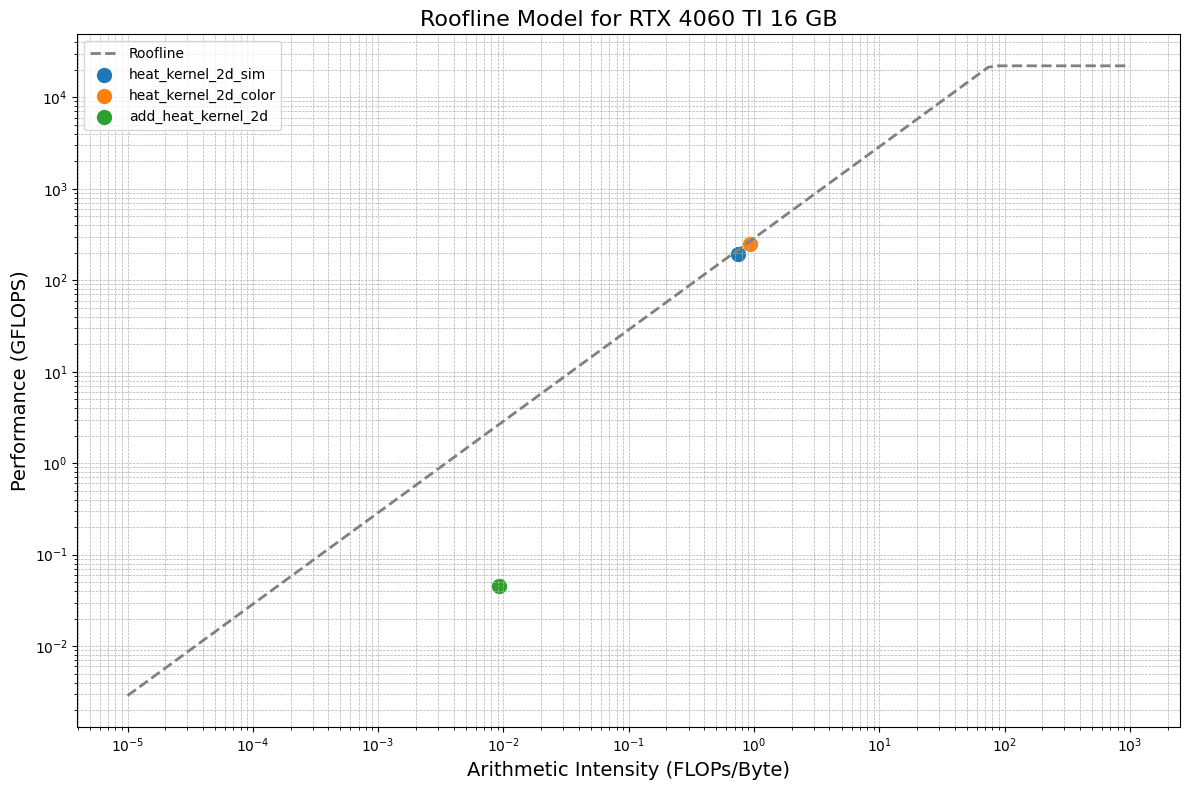

Target program: ['./cuda_heat_equation', '-d', '10', '100', '-b', 'N', '-m', '3d']
Profiling command: ncu --csv --metrics sm__sass_thread_inst_executed_op_dfma_pred_on.sum,sm__sass_thread_inst_executed_op_ffma_pred_on.sum,sm__sass_thread_inst_executed_op_dmul_pred_on.sum,sm__sass_thread_inst_executed_op_dadd_pred_on.sum,sm__sass_thread_inst_executed_op_fmul_pred_on.sum,sm__sass_thread_inst_executed_op_fadd_pred_on.sum,sm__sass_thread_inst_executed_op_imul_pred_on.sum,sm__sass_thread_inst_executed_op_iadd_pred_on.sum,smsp__thread_inst_executed_pred_on.sum,dram__bytes.sum,gpu__time_duration.sum ./cuda_heat_equation -d 10 100 -b N -m 3d
Running Nsight Compute...


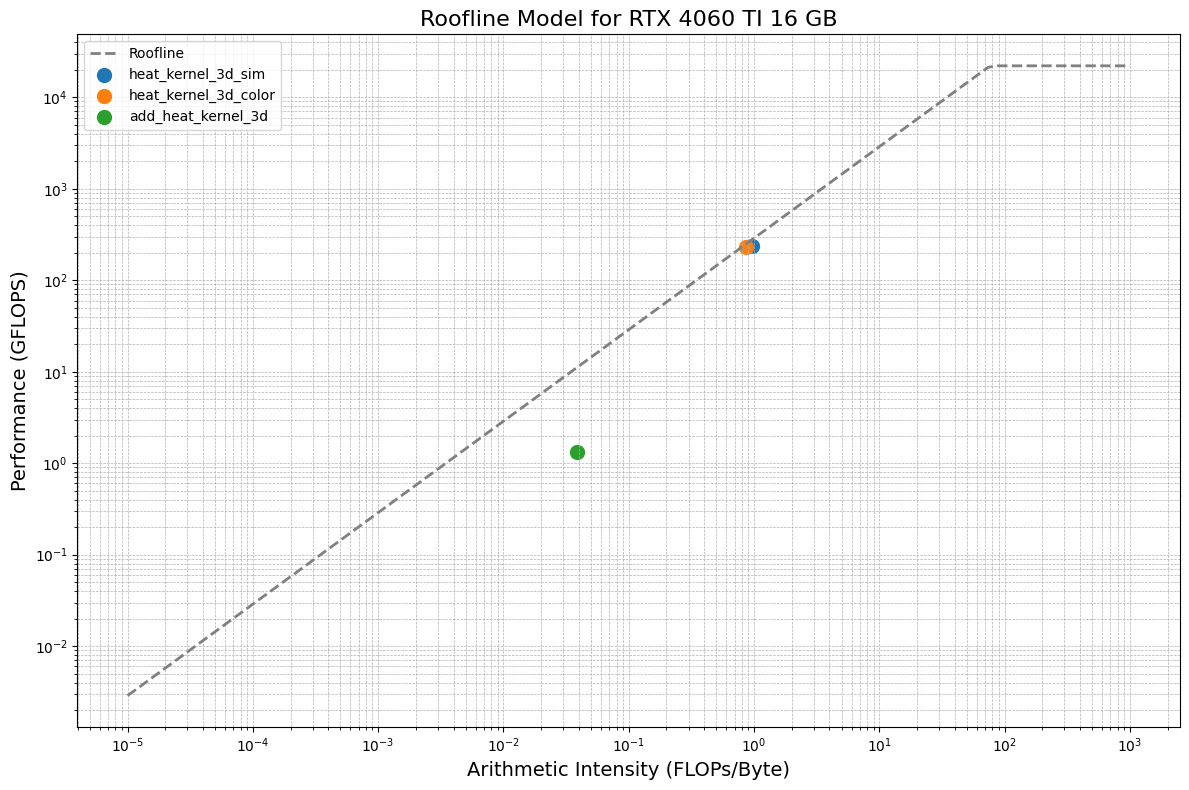

In [83]:
main(["./cuda_heat_equation", "-d 25 100 -b N -m 1d"])
main(["./cuda_heat_equation", "-d 25 100 -b N -m 2d"])
main(["./cuda_heat_equation", "-d 10 100 -b N -m 3d"])